# 04 — Custom models (WITHOUT LAMA)

Goal: beat the best LAMA baseline.

We implement **multiple pipelines**:
1) TF‑IDF (text) + OHE (cats) + numeric → **LogReg**
2) Target Encoding (cats) + numeric → **LightGBM**
3) CatBoost on tabular → **CatBoostClassifier**

Plus: **Optuna tuning** for LightGBM.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if (PROJECT_ROOT / "src").exists() is False and (PROJECT_ROOT.parent / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("src exists:", (PROJECT_ROOT / "src").exists())

PROJECT_ROOT: /Users/sergey/code/renthop-lightautoml-vs-custom
src exists: True


In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss

from src.config import Paths, TARGET_COL, ID_COL, SEED
from src.models.cv import stratified_cv_predict_proba
from src.models.custom import (
    make_tfidf_linear_pipeline,
    fit_predict_proba_sklearn,
    make_lgbm_target_enc_pipeline,
    fit_predict_proba_lgbm_target_enc,
    make_catboost_model,
    fit_predict_proba_catboost,
)
from src.utils.seed import set_global_seed

set_global_seed(SEED)
paths = Paths()

df = pd.read_pickle(paths.data_processed/"model_table.pkl")
spec = json.loads((paths.data_processed/"feature_spec.json").read_text(encoding="utf-8"))

train_df = df[df[TARGET_COL].notna()].copy()
test_df  = df[df[TARGET_COL].isna()].copy()

labels = ["high","medium","low"]

## Pipeline 1: TF‑IDF + Logistic Regression (strong baseline)

In [3]:
X = train_df[spec["numeric_cols"] + spec["categorical_cols"] + spec["text_cols"]].copy()
y = train_df[TARGET_COL].copy()

tfidf_pipe = make_tfidf_linear_pipeline(
    numeric_cols=spec["numeric_cols"],
    categorical_cols=spec["categorical_cols"],
    text_cols=spec["text_cols"],
    max_features=70000,
)

def fit_pred_fn(X_tr, y_tr, X_va):
    return fit_predict_proba_sklearn(tfidf_pipe, X_tr, y_tr, X_va)

res = stratified_cv_predict_proba(fit_pred_fn, X, y, labels=labels, n_splits=5, seed=SEED)
print("Mean CV logloss:", res.mean_score)

/Users/sergey/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/sergey/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 1: logloss=0.73001


/Users/sergey/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/sergey/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 2: logloss=0.74371


/Users/sergey/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/sergey/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 3: logloss=0.74084


/Users/sergey/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/sergey/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 4: logloss=0.73913


/Users/sergey/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/sergey/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 5: logloss=0.74178
Mean CV logloss: 0.7390945882567219


## Pipeline 2: Target Encoding + LightGBM

In [7]:
from lightgbm import LGBMClassifier

X_tab = train_df[spec["numeric_cols"] + spec["categorical_cols"]].copy()
y_tab = train_df[TARGET_COL].astype(str).copy()

num_cols = spec["numeric_cols"]
cat_cols = spec["categorical_cols"]

def _simplex(p, eps=1e-15):
    p = np.clip(p, eps, 1.0)
    return p / p.sum(axis=1, keepdims=True)

class TargetEncoderMulticlass:
    """Multiclass target encoding with smoothing; fit ONLY on train fold to avoid leakage."""
    def __init__(self, cat_cols, labels, smoothing=20.0):
        self.cat_cols = list(cat_cols)
        self.labels = list(labels)
        self.smoothing = float(smoothing)
        self.prior_ = None
        self.maps_ = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        y = y.astype(str)
        self.prior_ = y.value_counts(normalize=True).reindex(self.labels).fillna(0.0).values
        self.maps_ = {}
        for col in self.cat_cols:
            g = pd.crosstab(X[col].astype(str), y).reindex(columns=self.labels, fill_value=0)
            cnt = g.sum(axis=1).astype(float)
            probs = (g.div(cnt, axis=0).fillna(0.0) * cnt.values[:, None] + self.prior_ * self.smoothing) / (
                cnt.values[:, None] + self.smoothing
            )
            probs = pd.DataFrame(probs, index=g.index, columns=[f"{col}__te_{lab}" for lab in self.labels])
            self.maps_[col] = probs
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        parts = []
        for col in self.cat_cols:
            key = X[col].astype(str)
            m = self.maps_[col]
            joined = key.to_frame("key").merge(m, how="left", left_on="key", right_index=True).drop(columns=["key"])
            for j, lab in enumerate(self.labels):
                joined[f"{col}__te_{lab}"] = joined[f"{col}__te_{lab}"].fillna(self.prior_[j])
            parts.append(joined)
        return pd.concat(parts, axis=1)

def fit_pred_fn2(X_tr, y_tr, X_va):
    X_tr2 = X_tr.copy()
    X_va2 = X_va.copy()

    # numeric cleaning
    X_tr2[num_cols] = X_tr2[num_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    X_va2[num_cols] = X_va2[num_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)

    # categorical cleaning
    for c in cat_cols:
        X_tr2[c] = X_tr2[c].fillna("UNKNOWN").astype(str)
        X_va2[c] = X_va2[c].fillna("UNKNOWN").astype(str)

    # OOF-safe encoding (fit on train fold only)
    te = TargetEncoderMulticlass(cat_cols=cat_cols, labels=labels, smoothing=20.0).fit(X_tr2[cat_cols], y_tr)
    tr_te = te.transform(X_tr2[cat_cols])
    va_te = te.transform(X_va2[cat_cols])

    Xtr = pd.concat([X_tr2[num_cols].reset_index(drop=True), tr_te.reset_index(drop=True)], axis=1)
    Xva = pd.concat([X_va2[num_cols].reset_index(drop=True), va_te.reset_index(drop=True)], axis=1)

    clf = LGBMClassifier(
        objective="multiclass",
        n_estimators=2500,
        learning_rate=0.03,
        num_leaves=128,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
    )
    clf.fit(Xtr, y_tr.astype(str))
    return _simplex(clf.predict_proba(Xva))

res2 = stratified_cv_predict_proba(fit_pred_fn2, X_tab, y_tab, labels=labels, n_splits=5, seed=SEED)
print("Mean CV logloss:", res2.mean_score)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3128
[LightGBM] [Info] Number of data points in the train set: 39481, number of used features: 24
[LightGBM] [Info] Start training from score -2.553816
[LightGBM] [Info] Start training from score -0.364292
[LightGBM] [Info] Start training from score -1.480486
Fold 1: logloss=0.73636
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3134
[LightGBM] [Info] Number of data points in the train set: 39481, number of used features: 24
[LightGBM] [Info] Start training from score -2.553816
[LightGBM] [Info] Start training from score -0.364292


## Pipeline 3: CatBoost (tabular)

In [8]:
X_cb = train_df[spec["numeric_cols"] + spec["categorical_cols"]].copy()
y_cb = train_df[TARGET_COL].copy()

cb_model = make_catboost_model(cat_cols=spec["categorical_cols"], params={"iterations": 2000})

def fit_pred_fn3(X_tr, y_tr, X_va):
    m = make_catboost_model(cat_cols=spec["categorical_cols"], params={"iterations": 2000})
    return fit_predict_proba_catboost(m, X_tr, y_tr, X_va, cat_cols=spec["categorical_cols"])

res3 = stratified_cv_predict_proba(fit_pred_fn3, X_cb, y_cb, labels=labels, n_splits=5, seed=SEED)
print("Mean CV logloss:", res3.mean_score)

0:	learn: 1.0383353	total: 95.3ms	remaining: 3m 10s
200:	learn: 0.5076995	total: 6.73s	remaining: 1m
400:	learn: 0.4486259	total: 13.4s	remaining: 53.5s
600:	learn: 0.4016406	total: 20.3s	remaining: 47.2s
800:	learn: 0.3621353	total: 27.4s	remaining: 41s
1000:	learn: 0.3269755	total: 34.1s	remaining: 34.1s
1200:	learn: 0.2939820	total: 40.7s	remaining: 27.1s
1400:	learn: 0.2663413	total: 47.3s	remaining: 20.2s
1600:	learn: 0.2410479	total: 53.9s	remaining: 13.4s
1800:	learn: 0.2201921	total: 1m 1s	remaining: 6.74s
1999:	learn: 0.2011050	total: 1m 7s	remaining: 0us
Fold 1: logloss=0.56650
0:	learn: 1.0384919	total: 30.9ms	remaining: 1m 1s
200:	learn: 0.5063153	total: 6.59s	remaining: 59s
400:	learn: 0.4508975	total: 13.2s	remaining: 52.7s
600:	learn: 0.4042054	total: 19.9s	remaining: 46.4s
800:	learn: 0.3639399	total: 26.7s	remaining: 39.9s
1000:	learn: 0.3263706	total: 33.2s	remaining: 33.2s
1200:	learn: 0.2938173	total: 39.8s	remaining: 26.5s
1400:	learn: 0.2664846	total: 46.3s	remain

## Compare pipelines

,pipeline,logloss
2,CatBoost (tabular),0.562891
1,TargetEnc + LightGBM,0.722225
0,TF‑IDF + LogisticRegression,0.739095


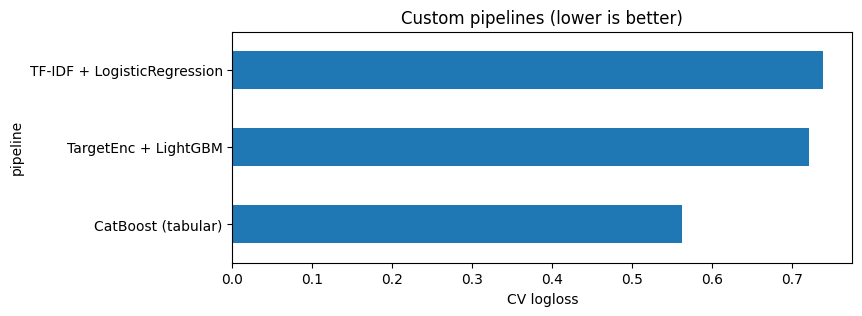

In [9]:
import pandas as pd

comp = pd.DataFrame([
    {"pipeline": "TF‑IDF + LogisticRegression", "logloss": res.mean_score},
    {"pipeline": "TargetEnc + LightGBM", "logloss": res2.mean_score},
    {"pipeline": "CatBoost (tabular)", "logloss": res3.mean_score},
]).sort_values("logloss")

display(comp)

ax = comp.set_index("pipeline")["logloss"].plot(kind="barh", figsize=(8,3))
ax.set_title("Custom pipelines (lower is better)")
ax.set_xlabel("CV logloss")
plt.show()

## Optuna tuning example (LightGBM)

In [ ]:
import optuna
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss


num_cols = spec["numeric_cols"]
cat_cols = spec["categorical_cols"]

class TargetEncoderMulticlass:
    def __init__(self, cat_cols, labels, smoothing=20.0):
        self.cat_cols = list(cat_cols)
        self.labels = list(labels)
        self.smoothing = float(smoothing)
        self.prior_ = None
        self.maps_ = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        y = y.astype(str)
        self.prior_ = y.value_counts(normalize=True).reindex(self.labels).fillna(0.0).values
        self.maps_ = {}
        for col in self.cat_cols:
            g = pd.crosstab(X[col].astype(str), y).reindex(columns=self.labels, fill_value=0)
            cnt = g.sum(axis=1).astype(float)
            probs = (g.div(cnt, axis=0).fillna(0.0) * cnt.values[:, None] + self.prior_ * self.smoothing) / (
                cnt.values[:, None] + self.smoothing
            )
            probs = pd.DataFrame(probs, index=g.index, columns=[f"{col}__te_{lab}" for lab in self.labels])
            self.maps_[col] = probs
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        parts = []
        for col in self.cat_cols:
            key = X[col].astype(str)
            m = self.maps_[col]
            joined = key.to_frame("key").merge(m, how="left", left_on="key", right_index=True).drop(columns=["key"])
            for j, lab in enumerate(self.labels):
                joined[f"{col}__te_{lab}"] = joined[f"{col}__te_{lab}"].fillna(self.prior_[j])
            parts.append(joined)
        return pd.concat(parts, axis=1)

def _simplex(p, eps=1e-15):
    p = np.clip(p, eps, 1.0)
    return p / p.sum(axis=1, keepdims=True)

def objective(trial: optuna.Trial) -> float:
    lgbm_params = {
        "objective": "multiclass",
        "n_estimators": 3000,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.08, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 32, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "random_state": SEED,
        "n_jobs": -1,
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    scores = []

    for tr_idx, va_idx in skf.split(X_tab, y_tab):
        X_tr, X_va = X_tab.iloc[tr_idx].copy(), X_tab.iloc[va_idx].copy()
        y_tr, y_va = y_tab.iloc[tr_idx].astype(str), y_tab.iloc[va_idx].astype(str)

        # clean
        X_tr[num_cols] = X_tr[num_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)
        X_va[num_cols] = X_va[num_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)
        for c in cat_cols:
            X_tr[c] = X_tr[c].fillna("UNKNOWN").astype(str)
            X_va[c] = X_va[c].fillna("UNKNOWN").astype(str)

        # OOF-safe target encoding
        te = TargetEncoderMulticlass(cat_cols=cat_cols, labels=labels, smoothing=20.0).fit(X_tr[cat_cols], y_tr)
        tr_te = te.transform(X_tr[cat_cols])
        va_te = te.transform(X_va[cat_cols])

        Xtr = pd.concat([X_tr[num_cols].reset_index(drop=True), tr_te.reset_index(drop=True)], axis=1)
        Xva = pd.concat([X_va[num_cols].reset_index(drop=True), va_te.reset_index(drop=True)], axis=1)

        model = LGBMClassifier(**lgbm_params)
        model.fit(Xtr, y_tr)
        proba = _simplex(model.predict_proba(Xva))
        scores.append(log_loss(y_va, proba, labels=labels))

    return float(np.mean(scores))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25, show_progress_bar=True)

print("Best params:", study.best_params)
print("Best value :", study.best_value)


[I 2025-12-27 23:43:19,822] A new study created in memory with name: no-name-790f88a6-50fd-4342-9c5d-1ce5e0ef3fed
  0%|          | 0/25 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3125
[LightGBM] [Info] Number of data points in the train set: 32901, number of used features: 24
[LightGBM] [Info] Start training from score -2.553886
[LightGBM] [Info] Start training from score -0.364289
[LightGBM] [Info] Start training from score -1.480468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3123
[LightGBM] [Info] Number of data points in the train set: 32901, number of used features: 24
[LightGBM] [Info] Start training from score -2.553886
[LightGBM] [Info] Start training from score -0.364289
[LightGBM] [Info] Start training from score -1.480468
[LightGBM] [Info] Auto-choosing ro

Best trial: 0. Best value: 1.04113:   4%|▍         | 1/25 [07:33<3:01:30, 453.75s/it]

[I 2025-12-27 23:50:53,578] Trial 0 finished with value: 1.041128356835503 and parameters: {'learning_rate': 0.07458909852679195, 'num_leaves': 93, 'min_child_samples': 25, 'subsample': 0.7573474334749423, 'colsample_bytree': 0.6893810973663567, 'reg_lambda': 0.3140116786569437}. Best is trial 0 with value: 1.041128356835503.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3120
[LightGBM] [Info] Number of data points in the train set: 32901, number of used features: 23
[LightGBM] [Info] Start training from score -2.553886
[LightGBM] [Info] Start training from score -0.364289
[LightGBM] [Info] Start training from score -1.480468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overh

Best trial: 1. Best value: 0.655669:   8%|▊         | 2/25 [13:06<2:26:39, 382.58s/it]

[I 2025-12-27 23:56:26,345] Trial 1 finished with value: 0.6556691237920297 and parameters: {'learning_rate': 0.023634357763504348, 'num_leaves': 65, 'min_child_samples': 152, 'subsample': 0.9289493003618727, 'colsample_bytree': 0.9965653748230724, 'reg_lambda': 2.7844872920959354}. Best is trial 1 with value: 0.6556691237920297.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3120
[LightGBM] [Info] Number of data points in the train set: 32901, number of used features: 23
[LightGBM] [Info] Start training from score -2.553886
[LightGBM] [Info] Start training from score -0.364289
[LightGBM] [Info] Start training from score -1.480468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Best trial: 1. Best value: 0.655669:  12%|█▏        | 3/25 [39:39<5:42:51, 935.09s/it]

[I 2025-12-28 00:22:58,914] Trial 2 finished with value: 0.6645478901982712 and parameters: {'learning_rate': 0.011794093383620582, 'num_leaves': 197, 'min_child_samples': 190, 'subsample': 0.738496406231064, 'colsample_bytree': 0.8771184550295908, 'reg_lambda': 0.006391509516634614}. Best is trial 1 with value: 0.6556691237920297.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3125
[LightGBM] [Info] Number of data points in the train set: 32901, number of used features: 24
[LightGBM] [Info] Start training from score -2.553886
[LightGBM] [Info] Start training from score -0.364289
[LightGBM] [Info] Start training from score -1.480468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

Best trial: 1. Best value: 0.655669:  16%|█▌        | 4/25 [2:22:28<17:30:31, 3001.51s/it]

[I 2025-12-28 02:05:48,251] Trial 3 finished with value: 1.4291228395079951 and parameters: {'learning_rate': 0.07200735841422413, 'num_leaves': 245, 'min_child_samples': 97, 'subsample': 0.8897612261357102, 'colsample_bytree': 0.8310059637325875, 'reg_lambda': 0.07867146793649814}. Best is trial 1 with value: 0.6556691237920297.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3125
[LightGBM] [Info] Number of data points in the train set: 32901, number of used features: 24
[LightGBM] [Info] Start training from score -2.553886
[LightGBM] [Info] Start training from score -0.364289
[LightGBM] [Info] Start training from score -1.480468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wis

Best trial: 1. Best value: 0.655669:  20%|██        | 5/25 [2:58:12<14:57:23, 2692.16s/it]

[I 2025-12-28 02:41:31,898] Trial 4 finished with value: 0.7134335410032846 and parameters: {'learning_rate': 0.027805043755762843, 'num_leaves': 105, 'min_child_samples': 18, 'subsample': 0.7769603636239479, 'colsample_bytree': 0.8155169630940956, 'reg_lambda': 3.0584769495181794}. Best is trial 1 with value: 0.6556691237920297.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3125
[LightGBM] [Info] Number of data points in the train set: 32901, number of used features: 24
[LightGBM] [Info] Start training from score -2.553886
[LightGBM] [Info] Start training from score -0.364289
[LightGBM] [Info] Start training from score -1.480468


Best trial: 1. Best value: 0.655669:  20%|██        | 5/25 [2:58:24<11:53:36, 2140.84s/it]


[W 2025-12-28 02:41:44,015] Trial 5 failed with parameters: {'learning_rate': 0.05813297607267338, 'num_leaves': 73, 'min_child_samples': 34, 'subsample': 0.8703997541368846, 'colsample_bytree': 0.6746588443077105, 'reg_lambda': 0.0036850726642862906} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/sergey/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/48/64q17bwx0vj129s9_p6bxt400000gn/T/ipykernel_15266/1375121380.py", line 86, in objective
    model.fit(Xtr, y_tr)
  File "/Users/sergey/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py", line 1560, in fit
    super().fit(
  File "/Users/sergey/Library/Python/3.9/lib/python/site-packages/lightgbm/sklearn.py", line 1049, in fit
    self._Booster = train(
  File "/Users/sergey/Library/Python/3.9/lib/python/site-packages/lightgbm/engine.py", line 322, in train
    booste

KeyboardInterrupt: 

## Train best custom pipeline on full train and create submission

In [11]:
# Choose best pipeline from comp table
best = comp.iloc[0]["pipeline"]
print("Best by CV:", best)

if best == "TF‑IDF + LogisticRegression":
    pipe = make_tfidf_linear_pipeline(spec["numeric_cols"], spec["categorical_cols"], spec["text_cols"], max_features=70000)
    X_full = train_df[spec["numeric_cols"] + spec["categorical_cols"] + spec["text_cols"]]
    y_full = train_df[TARGET_COL]
    pipe.fit(X_full, y_full)
    X_test = test_df[spec["numeric_cols"] + spec["categorical_cols"] + spec["text_cols"]]
    pred = pipe.predict_proba(X_test)

elif best == "TargetEnc + LightGBM":
    best_params = getattr(study, "best_params", {})
    enc, model = make_lgbm_target_enc_pipeline(spec["numeric_cols"], spec["categorical_cols"], params={**best_params, "n_estimators": 4000})
    X_full = train_df[spec["numeric_cols"] + spec["categorical_cols"]]
    y_full = train_df[TARGET_COL]
    enc.fit(X_full.fillna(0), y_full)
    X_full_enc = enc.transform(X_full.fillna(0))
    model.fit(X_full_enc, y_full)
    X_test = test_df[spec["numeric_cols"] + spec["categorical_cols"]]
    pred = model.predict_proba(enc.transform(X_test.fillna(0)))

else:
    model = make_catboost_model(cat_cols=spec["categorical_cols"], params={"iterations": 2500})
    X_full = train_df[spec["numeric_cols"] + spec["categorical_cols"]]
    y_full = train_df[TARGET_COL]
    cat_idx = [X_full.columns.get_loc(c) for c in spec["categorical_cols"]]
    model.fit(X_full, y_full, cat_features=cat_idx)
    X_test = test_df[spec["numeric_cols"] + spec["categorical_cols"]]
    pred = model.predict_proba(X_test)

sub = pd.DataFrame({ID_COL: test_df[ID_COL].values})
sub[labels] = pred

out_path = paths.submissions / "submission_custom_best.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
sub.to_csv(out_path, index=False)
print("Saved:", out_path)
sub.head()

Best by CV: CatBoost (tabular)
0:	learn: 1.0385392	total: 41.7ms	remaining: 1m 44s
200:	learn: 0.5117060	total: 8.08s	remaining: 1m 32s
400:	learn: 0.4616438	total: 16.2s	remaining: 1m 24s
600:	learn: 0.4200003	total: 24.7s	remaining: 1m 18s
800:	learn: 0.3837248	total: 32.8s	remaining: 1m 9s
1000:	learn: 0.3502063	total: 40.9s	remaining: 1m 1s
1200:	learn: 0.3200714	total: 49s	remaining: 53s
1400:	learn: 0.2946355	total: 57.1s	remaining: 44.8s
1600:	learn: 0.2712005	total: 1m 5s	remaining: 36.8s
1800:	learn: 0.2491401	total: 1m 13s	remaining: 28.5s
2000:	learn: 0.2299121	total: 1m 21s	remaining: 20.3s
2200:	learn: 0.2119127	total: 1m 29s	remaining: 12.2s
2400:	learn: 0.1961559	total: 1m 38s	remaining: 4.06s
2499:	learn: 0.1890752	total: 1m 42s	remaining: 0us
Saved: /Users/sergey/code/renthop-lightautoml-vs-custom/artifacts/submissions/submission_custom_best.csv


,listing_id,high,medium,low
0,7142618,0.133026,0.211727,0.655247
1,7210040,0.002350,0.976794,0.020856
2,7174566,0.000286,0.962801,0.036913
3,7191391,0.134113,0.385737,0.480150
4,7171695,0.000933,0.650233,0.348834
